# Figures for Manuscript

## Data load and prep

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

# something wacko with gpus
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import numpy as np
from sklearn import preprocessing
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [8, 8]
import seaborn as sns

import pandas as pd
from tqdm import tqdm_notebook

from bdl_tensorflow import *
from helper_functions import *
import itertools

In [2]:
omni = pd.read_hdf('data/omni_hourly_alldata_smallfilled.h5')
goes = pd.read_hdf('data/GOES_xrs_xhf_hourly_1986-2018.h5')
ext = pd.read_hdf('data/external_coefficients.h5')
cme = pd.read_hdf('data/cme_hourly_complete.h5')
p10s = pd.read_hdf('data/dst_est_ist.h5')

# let's use the most relevant SW measurements from omni
omni_use_cols = ['BX, nT (GSE, GSM)',
                'BY, nT (GSM)',
                'BZ, nT (GSM)',  
                'SW Proton Density, N/cm^3',  
                'SW Plasma Speed, km/s',  
                'SW Plasma Temperature, K',
                'SW Plasma flow long. angle',
                'SW Plasma flow lat. angle',]

# use all GOES data
goes_use_cols = ['short channel',
                'long channel']

# cme data to use
cme_use_cols = ['Central PA', 
                'Width',
                'Linear Speed',
                '2nd order speed: initial',
                 '2nd order speed: final',
                 '2nd order speed: 20R',
                 'Accel',
                'Mass',
                'Kinetic energy']

# p10 terms to use, just est for now
p10s_use_cols = ['est']

# let's focus on first zonal coefficients
ext_use_cols = ['q10']

In [3]:
# this script generates forecasts from the L1 models trained for a 
# given forecast length. Output is t_out, loc, conf_int
def forecast_l1(hours):
    data = load_data()

    in_cols = list(itertools.chain(omni_use_cols, p10s_use_cols))
    out_cols = p10s_use_cols

    data_in = data[in_cols].copy()
    data_out = data[out_cols].copy()

    ndat = data.shape[0]
    t = data.index
    
    loc, conf_int, t_out = shared_processing(hours, 'SW', data_in, data_out, t)
    
    return t_out, loc, conf_int
    
def forecast_both(hours):
    data = load_data()

    in_cols = list(itertools.chain(goes_use_cols, cme_use_cols, omni_use_cols, p10s_use_cols))
    out_cols = p10s_use_cols

    data_in = data[in_cols].copy()
    data_out = data[out_cols].copy()

    ndat = data.shape[0]
    t = data.index
    
    # only run if using CME or x-ray data
    data_in['short channel'] = np.log10(data_in['short channel']+1e-8)
    data_in['long channel'] = np.log10(data_in['long channel']+1e-8)
    data_in['Mass'] = np.log10(data_in['Mass'] + 1e13)
    data_in['Kinetic energy'] = np.log10(data_in['Kinetic energy'] + 1e27)
    
    loc, conf_int, t_out = shared_processing(hours, 'XrayCMESW', data_in, data_out, t)
    
    return t_out, loc, conf_int
    
def shared_processing(hours, st, data_in, data_out, t):
    lahead = hours
    train_percent = 0.9
    test_percent = 0.1
    val_percent = 0.0
    batch_size = 1000
    
    data_in_arr = data_in[0:-lahead].values.astype(np.float32)
    data_out_arr = data_out[lahead:].values.astype(np.float32)

    t_in = t[0:-lahead]
    t_out = t[lahead:]

    dataset = Dataset(data_in_arr, data_out_arr)

    data_in_train, \
    data_out_train, \
    data_in_test, \
    data_out_test, \
    data_in_val, \
    data_out_val, \
    t_train, \
    t_test,\
    t_val = dataset.split(batch_size,                                                                                               
                              train_frac=train_percent,                                                         
                              test_frac=test_percent,                                                                                         
                              ext_array=np.concatenate([t_in.values.reshape(-1,1),
                                                        t_out.values.reshape(-1,1)], axis=1))

    t_in_train = t_train[:,0]
    t_out_train = t_train[:,1]
    t_in_test = t_test[:,0]
    t_out_test = t_test[:,1]

    # normalize
    scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
    data_in_train_scaled = scaler_input.fit_transform(data_in_train)
    data_in_test_scaled = scaler_input.transform(data_in_test)
    data_in_arr_scaled = scaler_input.transform(data_in_arr)

    input_dim = data_in.shape[1]
    output_dim = data_out.shape[1]
    
    # reshape input data
    data_in_train_scaled = data_in_train_scaled.reshape(-1, 1, input_dim)
    data_in_test_scaled = data_in_test_scaled.reshape(-1, 1, input_dim)
    data_in_arr_scaled = data_in_arr_scaled.reshape(-1, 1, input_dim)
    
    lstm_dim_1 = 20
    lstm_dim_2 = 10
    lstm_dim_3 = 5
    lstm_dim_4 = 10

    dense_dim_1 = 5
    dense_dim_2 = 10
    dense_dim_3 = 5
    dense_dim_4 = 5
    
    # CHANGE HERE
    model_name = 'Estout_%sEst_Gaussian_mod_L20L10D10_t' % st + '%d' % hours
    model_save_path = 'models/' + model_name + '/model.h5'
    model_weights_path = 'models/' + model_name + '/cp.ckpt'

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_dim_1, return_sequences=True, input_shape=(1, input_dim)),
        tf.keras.layers.LSTM(lstm_dim_2, return_sequences=False),
        tf.keras.layers.Dense(dense_dim_2, 
                              activation='tanh'),
        tf.keras.layers.Dense(2, 
                              kernel_initializer=tf.keras.initializers.Constant(0), 
                              bias_initializer=tf.keras.initializers.Constant([0, 20])),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., 0:1], 
                                 scale=1e-3 + tf.math.softplus(1.0 * t[..., 1:])))
    ])

    model.compile(loss=negloglik_weight, 
                  optimizer=tf.keras.optimizers.Adam(lr=0.002), 
                  metrics=['mse'])

    model.load_weights(model_weights_path)

    post_model = model(data_in_arr_scaled)

    # minus sign for reverse skewness of Gumbel (if necessary)
    data_out_pred_loc = post_model.loc.numpy()
    data_out_pred_scale = post_model.scale.numpy()

    # make distributions from learned parameters
    data_out_pred = stats.norm(loc=data_out_pred_loc, scale=data_out_pred_scale)

    lb = data_out_pred.ppf(0.025)
    ub = data_out_pred.ppf(0.975)
    conf_int = np.concatenate((lb, ub), axis=1)
    return data_out_pred_loc, conf_int, t_out

def load_data():
    dst = omni['Dst (nT)']

    # form full dataframe
    data = pd.concat([omni[omni_use_cols], goes[goes_use_cols], p10s[p10s_use_cols], cme[cme_use_cols]], axis=1)
    return data

def negloglik_weight(y_true, py_pred):
    loss = -py_pred.log_prob(y_true)
    y_pred_loc = py_pred.loc
    y_true = math_ops.cast(y_true, y_pred_loc.dtype)
    loss = loss + 0.1*K.mean(math_ops.squared_difference(y_pred_loc, y_true), axis=-1)
    return loss

### evaluate models for given forecast lahead

In [4]:
# get model output for given lahead in time
lahead = 6

t_out, loc_l1, ci_l1 = forecast_l1(lahead)
_, loc_bt, ci_bt = forecast_both(lahead)

C:\Users\adrian\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
C:\Users\adrian\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


### misc

In [6]:
data_plot = pd.concat([omni, goes, p10s['est'], cme], axis=1)
# offset by lahead
est_lag = data_plot[lahead:]['est']
data_plot = data_plot[0:-lahead]

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Storm 4

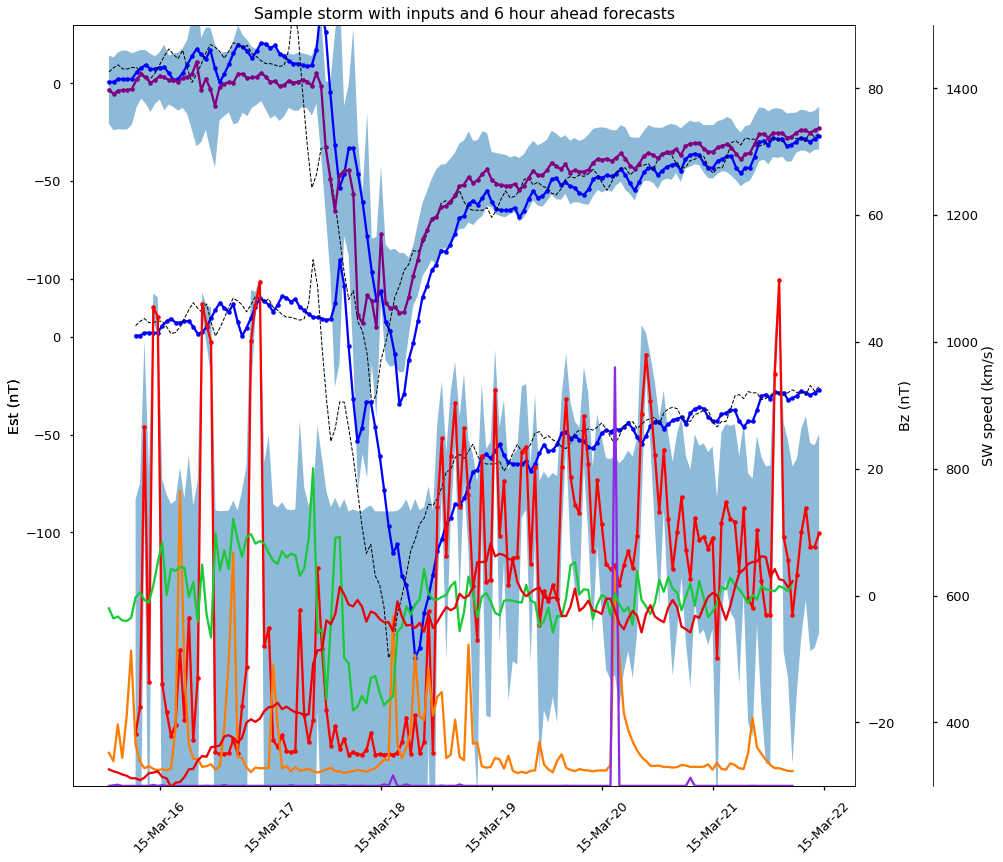

In [7]:
# storm 1
# idx = (t_out > np.datetime64('2016-10-05T12:00')) & \
#         (t_out  < np.datetime64('2016-10-21T00:00')) 

# storm 4
idx = (t_out > np.datetime64('2015-03-15T12:00')) & \
        (t_out < np.datetime64('2015-03-22T00:00'))

full_fmt = mdates.DateFormatter('%y-%b-%d, %H')
yr_mon_dd_fmt = mdates.DateFormatter('%y-%b-%d')
hour_tick = mdates.HourLocator()
day_tick = mdates.DayLocator()

cmap = sns.color_palette('bright')

fig = plt.figure(figsize=[14, 14])
ax1 = plt.axes() # est and forecast from L1
ax2 = fig.add_axes(ax1.get_position()) # est and forecast from L1 & solar disk

ax3 = ax2.twinx() # xray
ax4 = ax2.twinx() # CME kinetic energy
ax5 = ax2.twinx() # Bz
ax6 = ax2.twinx() # SW Plasma speed

# plot L1 model forecast
ax1.plot(t_out[idx], data_plot[idx]['est'], 'b.-', label='observed Est')
ax1.plot(t_out[idx], est_lag[idx], 'k--', label='Est at t', linewidth=1.0)
ax1.plot(t_out[idx], loc_l1[idx], '.-', label='predicted max\nlikelihood', color='purple')
ax1.fill_between(t_out[idx],
                ci_l1[idx, 0],
                ci_l1[idx, 1],
                label='2.5% - 97.5% \npercentile envelope',
                alpha=0.5)

# plot both model forecast
ax2.plot(t_out[idx], data_plot[idx]['est'], 'b.-', label='observed Est')
ax2.plot(t_out[idx], est_lag[idx], 'k--', label='Est at t', linewidth=1.0)
ax2.plot(t_out[idx], loc_bt[idx], 'r.-', label='predicted max\nlikelihood')
ax2.fill_between(t_out[idx],
                ci_bt[idx, 0],
                ci_bt[idx, 1],
                label='2.5% - 97.5% \npercentile envelope',
                alpha=0.5)



l_xray = ax3.plot(data_plot[idx]['long channel'], label='solar X-ray flux', color=cmap[1])
l_cme = ax4.plot(data_plot[idx]['Kinetic energy'], label='CME energy', color=cmap[4])
l_bz = ax5.plot(data_plot[idx]['BZ, nT (GSM)'], label='southward B', color=cmap[2])
l_v = ax6.plot(data_plot[idx]['SW Plasma Speed, km/s'], label='SW speed', color=cmap[3])

# L1 model output
ax1.xaxis.set_major_formatter(yr_mon_dd_fmt)
ax1.tick_params(axis='x', rotation=45)
ax1.xaxis.set_major_locator(day_tick)
# ax1.xaxis.set_minor_locator(hour_tick)
ax1.set_ylim([-360, 30])
ax1.set_yticks([0, -50, -100])
ax1.set_ylabel('Est (nT)')

# both model output
ax2.set_ylim([-230, 160])
ax2.set_yticks([0, -50, -100])
ax2.set_ylabel('Est (nT)')

ax5.yaxis.set_label_position('right')
ax5.yaxis.set_ticks_position('right')
ax6.yaxis.set_label_position('right')
ax6.yaxis.set_ticks_position('right')

ax2.get_xaxis().set_visible(False)

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

ax5.get_xaxis().set_visible(False)
# ax4.get_yaxis().set_visible(False)

ax6.get_xaxis().set_visible(False)
# ax5.get_yaxis().set_visible(False)
ax6.spines["right"].set_position(("axes", 1.1))

make_patch_spines_invisible(ax2)
make_patch_spines_invisible(ax3)
make_patch_spines_invisible(ax4)
make_patch_spines_invisible(ax5)

ax6.spines["right"].set_visible(True)

ax5.set_ylabel('Bz (nT)')
ax6.set_ylabel('SW speed (km/s)')

ax3.set_ylim([0, 2e-5])
ax4.set_ylim([0, 8e31])
ax5.set_ylim([-30, 90])
ax6.set_ylim([300, 1500])

# lns = l_est + l_xray + l_cme + l_bz + l_v
# labs = [l.get_label() for l in lns]
# plt.legend(lns, labs, loc='lower right')
plt.title('Sample storm with inputs and 6 hour ahead forecasts')
# plt.savefig('figures/storm1.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Reliability diagrams